In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from skimage.transform import resize
from gvxrPython3 import gvxr
from gvxrPython3.JSON2gVXRDataReader import *
from cil.framework import ImageData, ImageGeometry, AcquisitionGeometry
from cil.utilities.display import show2D
from cil.utilities.jupyter import islicer
from cil.plugins.astra import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.processors import Binner
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares

In [82]:
def create_grid(tilt=0, flip=False, shape = (64, 256, 256)):
    # Create a circular grid phantom in a volume with shape (Y, X, Z)
    shape = (shape[0]*2, shape[1]*2, shape[2]*2)
    volume = np.zeros(shape, dtype=np.float32)

    margin = 32
    center_x, center_z = shape[1] // 2, shape[2] // 2
    radius = min(center_x, center_z) - margin
    edge_thickness = 1
    x_vals = np.arange(margin, shape[1] - margin)
    z_vals = np.arange(margin, shape[2] - margin)
    xx, zz = np.meshgrid(x_vals, z_vals, indexing='ij')  

    r2 = (xx - center_x)**2 + (zz - center_z)**2
    cylinder_mask = r2 <= radius**2
    cylinder_edge_mask = (r2 >= (radius - edge_thickness)**2) & (r2 <= (radius + edge_thickness)**2)

    grid_spacing = 32

    for xi, x in enumerate(x_vals):
        for zi, z in enumerate(z_vals):
            if not cylinder_mask[xi, zi]:
                continue
            if (x % grid_spacing == 0) or (z % grid_spacing == 0):
                volume[margin:shape[0]-margin, x, z] = 1.0

    for xi, x in enumerate(x_vals):
        for zi, z in enumerate(z_vals):
            if cylinder_edge_mask[xi, zi]:
                volume[margin:shape[0]-margin, x, z] = 1.0

    if flip:
        volume = np.rot90(volume, k=1, axes=(0, -1))
        ig = ImageGeometry(voxel_num_x=shape[0], voxel_num_y=shape[1], voxel_num_z=shape[2],
                        dimension_labels = ('horizontal_y', 'vertical', 'horizontal_x'))
        # ig.dimension_labels = ('horizontal_y', 'vertical', 'horizontal_x')
        grid = ImageData(volume, geometry=ig)
        grid.reorder('astra')
    else:
        ig = ImageGeometry(voxel_num_z=shape[0], voxel_num_x=shape[2], voxel_num_y=shape[1])
        ig.dimension_labels = ('vertical', 'horizontal_y', 'horizontal_x')
        grid = ImageData(volume, geometry=ig)

    tilt_rad = np.deg2rad(tilt)
    tilt_axis = np.array([1, 0, 0])
    rotation_axis = np.array([0, 0, 1]) # untilted rotation axis
    rotation_matrix = Rotation.from_rotvec(tilt_rad * tilt_axis)
    tilted_rotation_axis = rotation_matrix.apply(rotation_axis)

    ag = AcquisitionGeometry.create_Parallel3D(rotation_axis_direction=tilted_rotation_axis)\
        .set_angles(np.arange(0,360))\
        .set_panel([shape[1], shape[2]])
    ag.dimension_labels = ('vertical', 'angle','horizontal')

    A = ProjectionOperator(ig, ag)
    proj = A.direct(grid)
    proj.array += 0.01 * proj.max() * np.random.randn(*proj.shape).astype(np.float32)
    proj.array = np.clip(proj.array, 0, None)

    roi = {'horizontal': (None, None, 2),
            'vertical': (None, None, 2),
            'angle': (None, None, 2)}
    proj = Binner(roi=roi)(proj)

    roi = {'horizontal_x': (None, None, 2),
            'vertical': (None, None, 2),
            'horizontal_y': (None, None, 2)}
    grid = Binner(roi=roi)(grid)

    return grid, proj


We start by simulating a flat circular mesh grid in a 3D volume

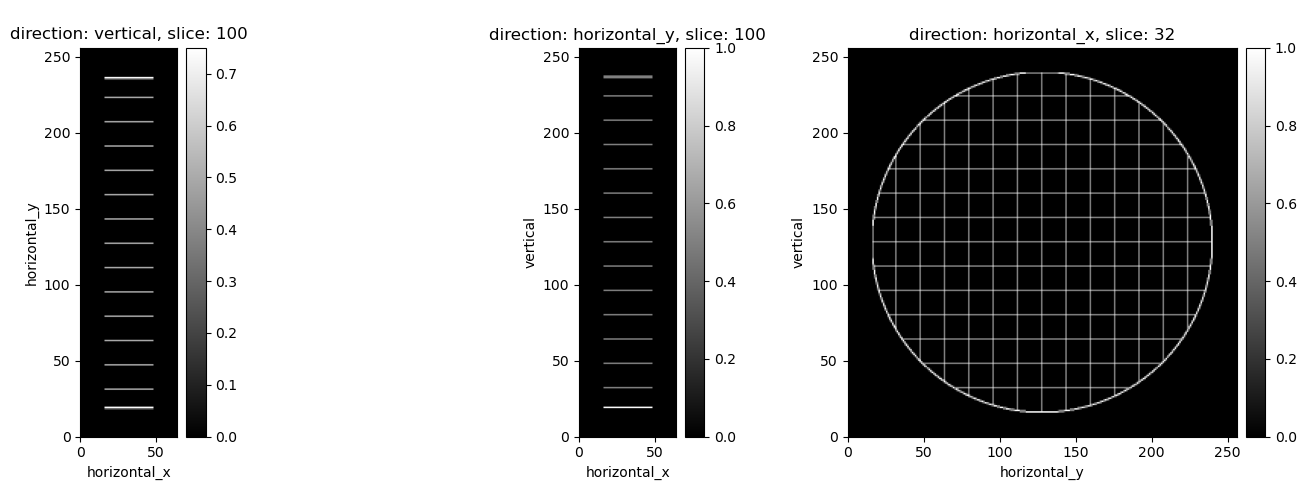

In [84]:
# call the create_grid function to get a grid and set of projections
grid, proj = create_grid(flip=True)

# then show what the volume looks like from 3 different directions
ax = show2D(grid,
       slice_list=[
           ('vertical', 100),
           ('horizontal_y', 100),  
           ('horizontal_x', grid.shape[2]//2),
       ],
       num_cols=3,
       size=(15,5))


We simulate the projections which would be generated by the grid in a parallel beam CT geometry setup

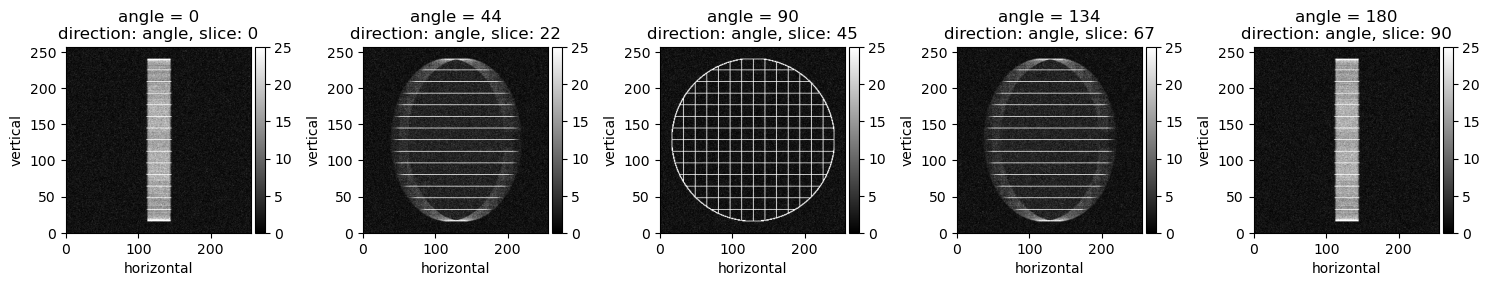

In [85]:
ag = proj.geometry
ig = ag.get_ImageGeometry()
# then we use a projection operator to simulate the projections

angles_to_show = [0, 45, 90, 135, 180]

ag_slice_list = [('angle', np.argmin(np.abs(ag.angles - a))) for a in angles_to_show]
titles = [f'angle = {ag.angles[np.argmin(np.abs(ag.angles - a))]:.0f}' for a in angles_to_show]

show2D(proj,
       slice_list = ag_slice_list, 
       title = titles,
       num_cols=5,
       fix_range=(0,25))

Notice that the projections have quite different levels of intensity at different projections as we look through the long and short plane of the flat sample.

Let's see what it looks like if we try to reconstruct the grid from these projections.

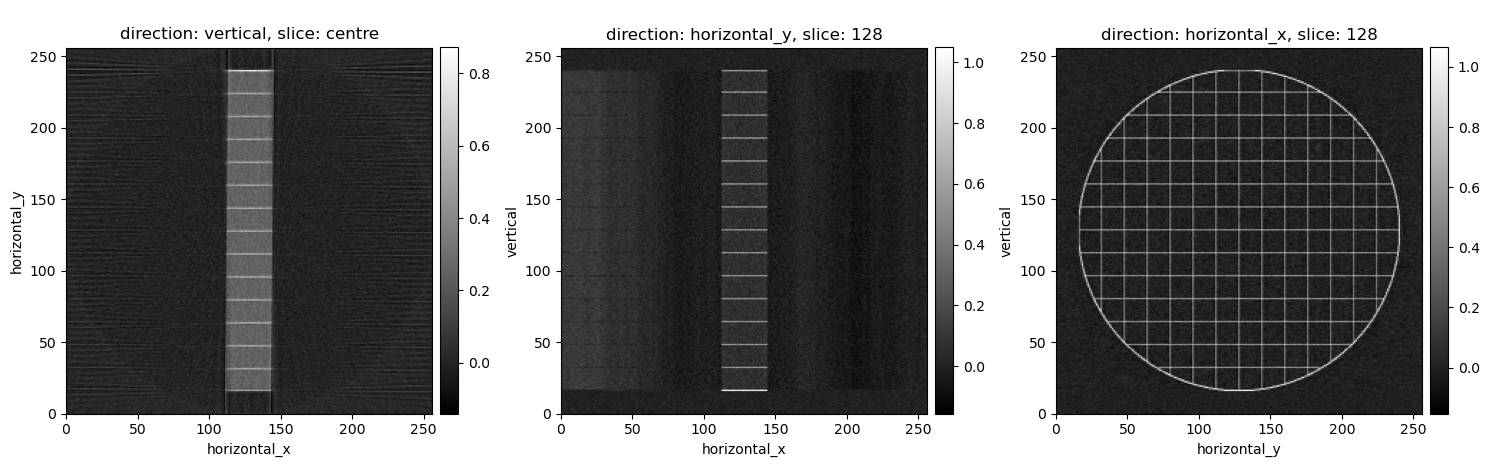

In [86]:
# Run the reconstruction
recon = FBP(image_geometry=None, acquisition_geometry=ag)(proj)

slice_list = [('vertical','centre'), ('horizontal_y',int(recon.shape[2]/2)), ('horizontal_x',int(recon.shape[1]/2))]
show2D(recon,
       slice_list=slice_list,
       num_cols=3)

We notice some strange artefacts in the reconstruction. This is because of the anisotropic absorption we noticed in the projections.

A common solution to these kind of artefacts is to tilt the sample and rotation axis to give a more uniform absorption profile, this setup is called laminography. We can simulate the laminography setup by projecting the original grid volume with a tilted rotation axis

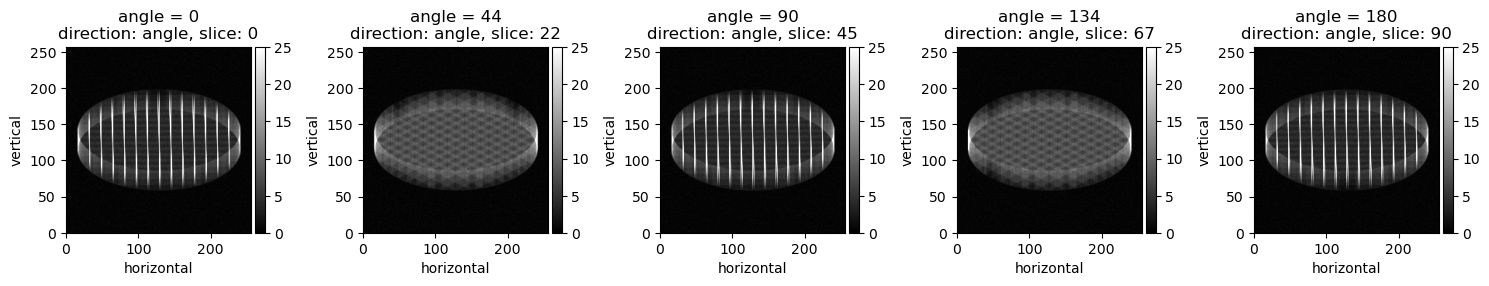

In [88]:
# first re-create the grid on the z-y plane and tilt 30 degrees
tilt = 30 # degrees
grid, proj = create_grid(tilt=tilt)

show2D(proj,
       slice_list = ag_slice_list, 
       title = titles,
       num_cols=5,
       fix_range=(0,25))

The projections now have very uniform attenuation. Let's try reconstructing this dataset

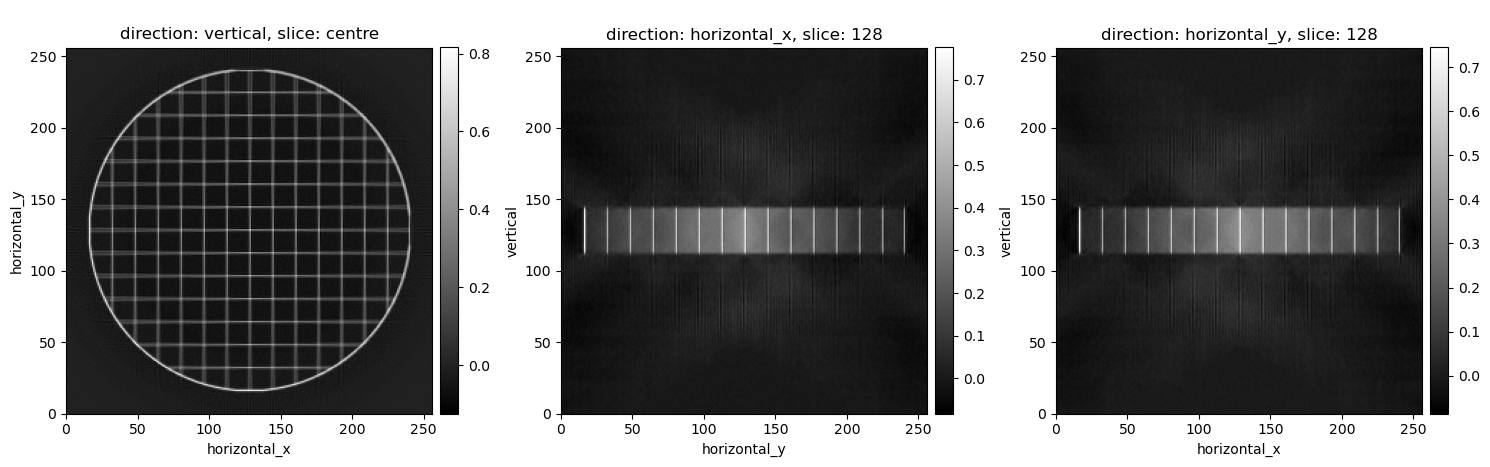

In [91]:
recon_tilt = FBP(image_geometry=None, acquisition_geometry=proj.geometry)(proj)

slice_list = [('vertical','centre'), ('horizontal_x',int(recon_tilt.shape[1]/2)), ('horizontal_y',int(recon_tilt.shape[2]/2))]
show2D(recon_tilt,
       slice_list=slice_list,
       num_cols=3)

We also also see artefacts in this reconstruction in the form of a halo around the object, these are due to the way the laminography setup causes an uneven distribution of projections. When considering using the laminography setup, we need to balance the impact of the different kinds of artefacts. In general we should use the smallest tilt angle possible to reduce the projection anisotropy.

Below we plot a cross-section through the reconstruction when the sample is tilted between 0 and 90 degrees, which shows how the halo effect varies with tilt.

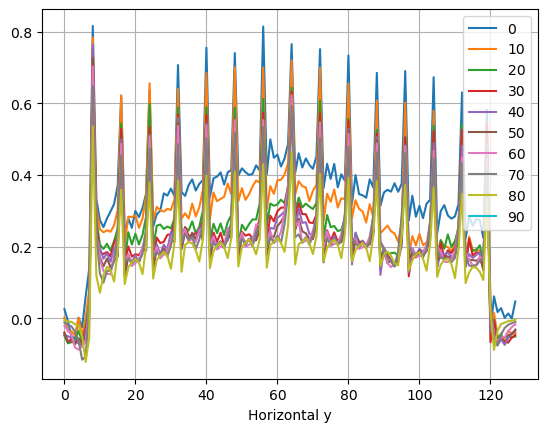

In [48]:
for tilt in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
    grid, proj = create_grid(tilt=tilt)

    recon_tilt = FBP(image_geometry=None, acquisition_geometry=proj.geometry)(proj)
    plt.plot(recon_tilt.array[64, :, 64], label=tilt)

plt.xlabel('Horizontal y')
plt.legend()
plt.grid()

If these artefacts are unacceptable, we can try an alternative reconstruction method like FISTA. Below we use FISTA with a least squares objective function, FGP_TV regularisation and a non-negativity constraint. For more details about these methods see [CIL-Demos: laminography](https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/2_Iterative/05_Laminography_with_TV.ipynb)

In [92]:
# Create the projections
tilt = 30
grid, proj = create_grid(tilt=tilt)

ag = proj.geometry
ig = ag.get_ImageGeometry()

recon_tilt = FBP(ig, ag)(proj)

A = ProjectionOperator(ig, ag)

# Recontruct with FISTA least squares with non-negativity constraint
LS = LeastSquares(A=A, b=proj)

alpha = 0.005
TV = FGP_TV(alpha=alpha, nonnegativity=True, device='gpu')

fista_TV = FISTA(initial=recon_tilt, f=LS, g=TV, update_objective_interval=10)
fista_TV.run(30)
TV_reco = fista_TV.solution

  0%|          | 0/30 [00:00<?, ?it/s]

Plot the different reconstructions and check the effect on the background

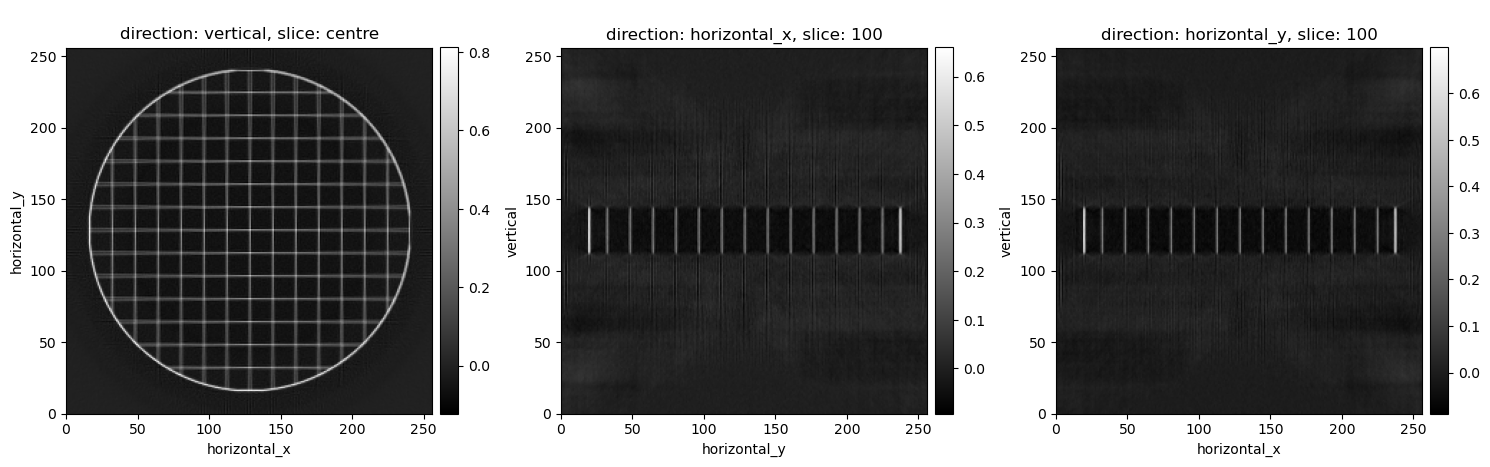

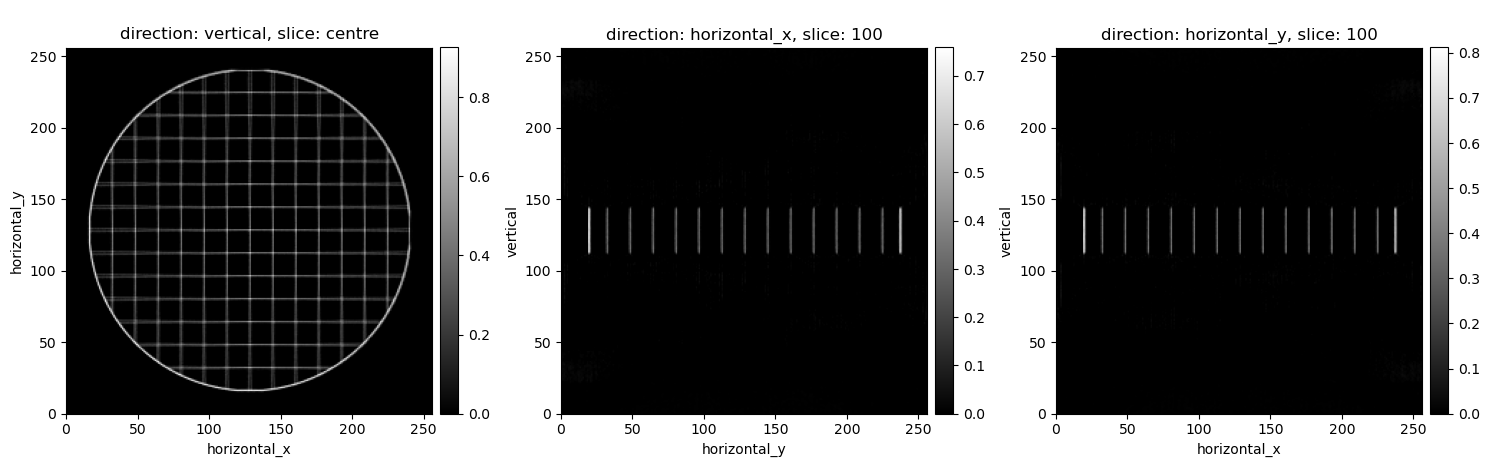

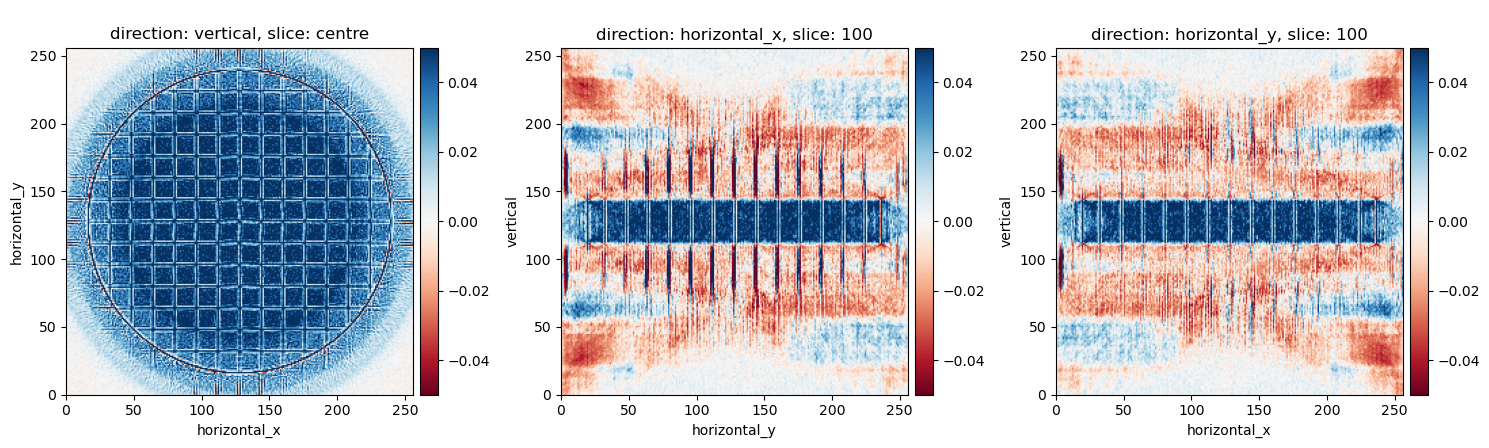

In [104]:
slice_list = [('vertical','centre'), ('horizontal_x',100), ('horizontal_y',100)]
show2D(recon_tilt,
       slice_list=slice_list,
       num_cols=3)
show2D(TV_reco,
       slice_list=slice_list,
       num_cols=3)
show2D(TV_reco-recon_tilt,
       slice_list=slice_list,
       num_cols=3,
       cmap="RdBu", 
       fix_range=(-0.05, 0.05))